In [1]:
%matplotlib ipympl
from fitting import setup_numpyro
from orbit_fitting import keplerian,rot_orbital_elements,kepler_III
cpu_cores = 4
setup_numpyro(cpu_cores)
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit
from numpy.random import normal
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
from jax.random import PRNGKey, split
import arviz
from corner import corner
plt.style.use('dark_background')

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


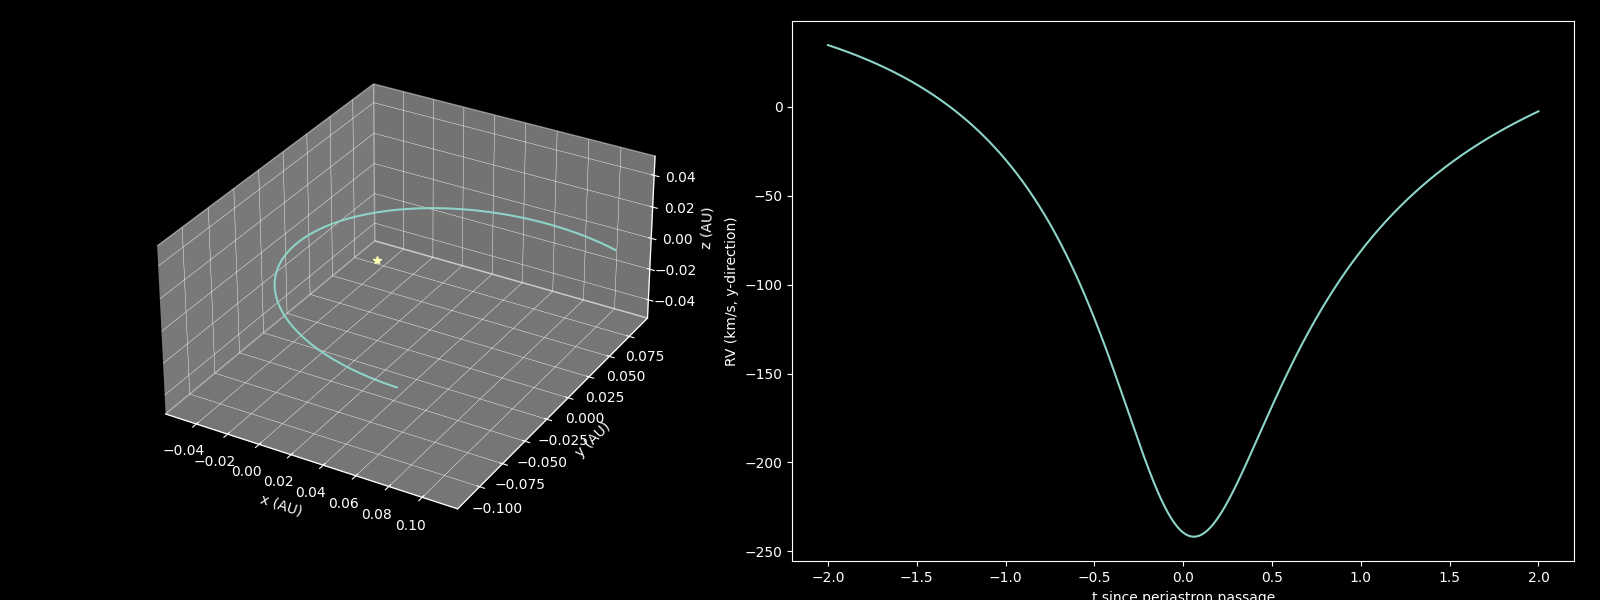

In [3]:
import astropy.constants as const
t = jnp.linspace(-2,2,5000)
au = const.au.value

a_real = 0.12 #AU
i_real = 0 #deg
w_real = -10 #deg
W_real = 180 #deg
e_real = 0.6
Mstar = 2.0

r,T,x,y,vx,vy = keplerian(t,a_au=a_real,e=e_real,M_Msun=Mstar)
z = r*0.0
vz = r*0.0

x,y,z = rot_orbital_elements(x,y,z,inc = np.radians(i_real),omega=np.radians(w_real),Omega=np.radians(W_real))
vx,vy,vz = rot_orbital_elements(vx,vy,vz,inc = np.radians(i_real),omega=np.radians(w_real),Omega=np.radians(W_real))
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1,projection='3d')
ax2= fig.add_subplot(1,2,2)
fig.tight_layout()
ax.plot(x/au,y/au,z/au,label='Orbit 1')
ax.plot(0,0,0,'*')
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
ax.set_zlabel('z (AU)')
ax.set_aspect('equal')
ax.xaxis._axinfo["grid"]['linewidth'] = 0.3
ax.yaxis._axinfo["grid"]['linewidth'] = 0.3
ax.zaxis._axinfo["grid"]['linewidth'] = 0.3

ax2.plot(t,vy/1e3)
ax2.set_xlabel('t since periastron passage')
ax2.set_ylabel('RV (km/s, y-direction)')
# ax2.set_xlim(-0.2,0.2)
# ax2.set_ylim(-70,20)
plt.show()

In [5]:
t0_real = 2.0

t = jnp.linspace(0,3,50)

r,T,x,y,vx,vy = keplerian(t-t0_real,a_au=a_real,e=e_real,M_Msun=Mstar)
vz = r*0.0
vx,vy,vz = rot_orbital_elements(vx,vy,vz,inc = np.radians(i_real),omega=np.radians(w_real),Omega=np.radians(W_real))


unc = 3000.0

RV = vy+normal(scale=unc,size=len(t))

a real: 0.12
e real: 0.6
w real: -10
t0_real: 2.0
Real period (d):  10.736316312870096


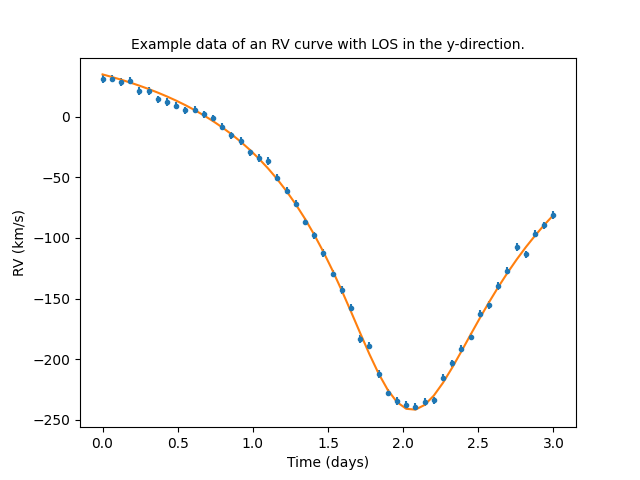

In [11]:
@jit
def RV_model(t,a,e,i,w,W,t0):
    r,T,x,y,vx,vy = keplerian(t-t0,a_au=a,e=e,M_Msun=2.0)
    vz = t*0.0
    vx,vy,vz = rot_orbital_elements(vx,vy,vz,inc = jnp.radians(i),omega=jnp.radians(w),Omega=jnp.radians(W))
    return(vy)

print('a real:',a_real)
print('e real:',e_real)
print('w real:',w_real)
print('t0_real:',t0_real)
print('Real period (d): ',kepler_III(a_real*const.au.value,Mstar*const.M_sun.value)/3600/24.0)

def numpyro_model():
    a = numpyro.sample('a', dist.LogUniform(low=0.05, high=0.2))
    e = numpyro.sample('e', dist.Uniform(low=0.0,high=0.9999))
    i = 0.0
    w = numpyro.sample('w', dist.Uniform(low=-60,high=20.0))
    W = 180.0
    t0 = numpyro.sample('t0',dist.Uniform(low=0,high=4))

    numpyro.sample("obs",dist.Normal(loc=RV_model(t,a,e,i,w,W,t0),scale=t*0.0+unc),obs=RV)



plt.figure()
plt.errorbar(t,RV/1e3,fmt='.',yerr=unc/1e3)
plt.plot(t,RV_model(t,a_real,e_real,i_real,w_real,W_real,t0_real)/1e3)
plt.title('Example data of an RV curve with LOS in the y-direction.',fontsize=10)
plt.xlabel('Time (days)')
plt.ylabel('RV (km/s)')
plt.show()

In [12]:
# Random numbers in jax are generated like this:
rng_seed = 42
rng_keys = split(
    PRNGKey(rng_seed), 
    cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model, 
    dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=5000, 
    num_samples=1000, 
    num_chains=cpu_cores
)

# Run the MCMC
mcmc.run(rng_keys)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

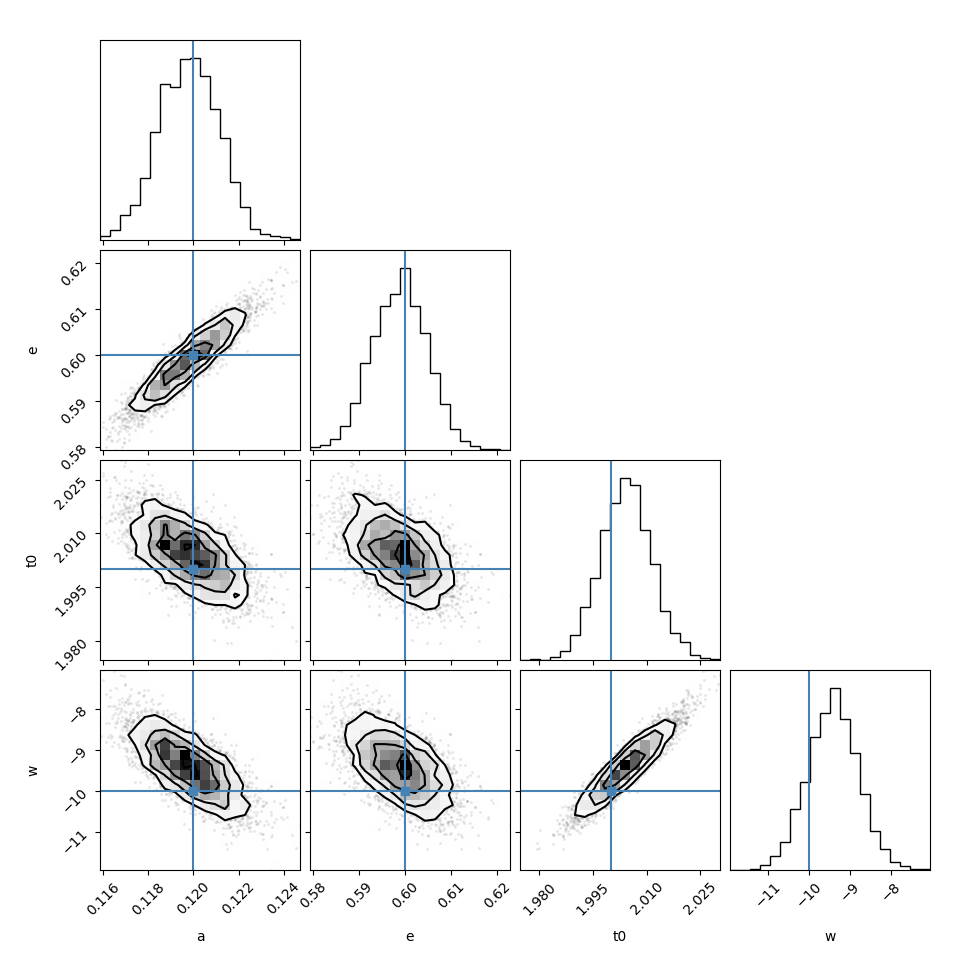

In [13]:
# arviz converts a numpyro MCMC object to an `InferenceData` object based on xarray:
result = arviz.from_numpyro(mcmc)

# these are the inputs to the synthetic double-gaussian profile (blue lines)
truths = [a_real, e_real, t0_real,w_real]

# make a corner plot
plt.style.use('default')
corner(
    result, 
    quiet=True,
    truths=truths
);